# Imports



In [1]:
import sys
import os
import molgroups as mol
import components as cmp
import lipids
import numpy as np

from bumps.cli import load_model, load_best
import matplotlib.pyplot as plt
import rs

# Variables

Variables to set the storage folder for the fit, the base name of the runfile, and the global optimizer. Further the
number of burn and production stepst for the MCMC are set. The run flag determines whether the refl1d MCMC is run, or
just a data analysis on a previous fit is performed.

In [2]:
store = "fit"
setupdir = os.getcwd()
runfile = "tblm"
fitsource = "refl1d"

if not os.path.isdir(store):
    os.mkdir(store)

run = True
burn = 1000
steps = 50


# Example Fit

The content of the following cell is written out to the runfile for the fit 'tblm.py'.

In [3]:
%%writefile tblm.py
## === Import section ===

import sys
# append path to your molgroups, or just link molgroups to your same directory
sys.path.append('')
import numpy as np
import molgroups as mol
import components as cmp
import lipids
from refl1d.names import load4, Parameter, SLD, Slab, Stack, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

## === Film structure definition section ===

### Bilayer profile definition function

def bilayer(z, sigma, bulknsld, global_rough, rho_substrate,nf_tether, mult_tether, l_tether, l_lipid1, l_lipid2, vf_bilayer):
    """ Generic tethered bilayer """

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld = bulknsld * 1e-6
    rho_substrate = rho_substrate * 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate,
              nf_tether=nf_tether, mult_tether=mult_tether, l_tether=l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
              vf_bilayer=vf_bilayer)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # Return nSLD profile in Refl1D units
    return nsld * 1e6

# Define bilayer parameters
vf_bilayer = Parameter(name='volume fraction bilayer', value=0.9).range(0.0, 1.0)
l_lipid1 = Parameter(name='inner acyl chain thickness', value=10.0).range(8, 30)
l_lipid2 = Parameter(name='outer acyl chain thickness', value=10.0).range(8, 16)
sigma = Parameter(name='bilayer roughness', value=5).range(2, 9)
global_rough = Parameter(name ='substrate roughness', value=5).range(2, 9)
d_oxide = Parameter(name='silicon oxide layer thickness', value=10).range(5, 30)
d_Cr =  Parameter(name='chromium layer thickness', value=40).range(10, 150)
d_gold =  Parameter(name='gold layer thickness', value=100).range(150, 250) #thickness of gold
rough_cr_au =  Parameter(name='gold chromium roughness', value=10).range(2, 24.0) # roughness of Cr/Au interface
nf_tether =  Parameter(name='number fraction tether', value=0.7).range(0.2, 1.0) # number fraction of tether molecules in inner leaflet
mult_tether =  Parameter(name='bME to tether ratio', value=2).range(0.1, 4) #ratio of bME to tether molecules at surface
l_tether =  Parameter(name='tether length', value=10).range(3, 18) #distance from substrate to inner headgroup/acyl chain interface

### Define bilayer object
blm = mol.tBLM(tether=cmp.HC18SAc, filler=cmp.bmeSAc, lipids=[lipids.POPC], lipid_nf=[1.0])        # required to subtract the bilayer length in layer_tiox definition; only really necessary if using "global blm" in bilayer function

### Define molgroups space.
dimension=300       # Number of steps

# Length of steps. Also sets calculation resolution, and determines speed of calculation
stepsize=0.5

## === Stack ===
##
## First, we create a 'material' for each bulk layer, which has an real and imaginary
## scattering length density, stored in a Refl1d object called 'SLD'
d2o = SLD(name='d2o', rho=6.3000, irho=0.0000)
h2o = SLD(name='h2o', rho=-0.56, irho=0.0000)
siox = SLD(name='siox', rho=4.1000, irho=0.0000)
silicon = SLD(name='silicon', rho=2.0690, irho=0.0000)
cr = SLD(name='chromium', rho=2.7, irho=0.0)
gold = SLD(name='gold', rho=4.4, irho=0.0) #iro is the absorption of neutrons, should be 0

## Then bulk layers are created, each with its own 'material'.  If you want to force
## two layers to always match SLD you can use the same material in multiple layers.
## The roughnesses of each layer are set to zero to begin with:

layer_d2o = Slab(material=d2o, thickness=0.0000, interface=5.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=5.0000)
layer_siox = Slab(material=siox, thickness=d_oxide, interface=global_rough)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=global_rough)
layer_cr = Slab(material=cr, thickness=d_Cr, interface=rough_cr_au)
layer_gold = Slab(material=gold, thickness=d_gold - (blm.substrate.z + 0.5 * blm.substrate.l), interface=0.0000)

## Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
## Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma, bulknsld=d2o.rho,
                             global_rough=global_rough, rho_substrate=gold.rho, nf_tether = nf_tether,
                             mult_tether = mult_tether, l_tether = l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                             vf_bilayer=vf_bilayer)

mollayerh = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma, bulknsld=h2o.rho,
                              global_rough=global_rough, rho_substrate=gold.rho, nf_tether = nf_tether,
                              mult_tether = mult_tether, l_tether = l_tether, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                              vf_bilayer=vf_bilayer)

## Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
## As a convention, always build the sample from the substrate up. If the neutron beam is incident from the substrate side,
## set back_reflectivity = True in the probe definition later.

sample = layer_silicon | layer_siox | layer_cr | layer_gold | mollayer | layer_d2o
sampleh = layer_silicon | layer_siox | layer_cr | layer_gold | mollayerh | layer_h2o

## Set sample parameter ranges and constraints between layer properties, if these are not set using parameters previously

# nSLD parameters
d2o.rho.range(5.3000, 6.5000)
h2o.rho.range(-0.6, 0.6)
siox.rho.range(3.1000, 5.1000)
cr.rho.range(2.7000, 4.0000)
gold.rho.range(4.2000, 4.8000)

## === Data files ===
probe = load4('os046_4column.refl', back_reflectivity=True)
probeh = load4('os047_4column.refl', back_reflectivity=True)

# Background parameter
# probe.background.value = 0.0000
probe.background.range(-1e-7, 1e-5)
probeh.background.range(-1e-7, 1e-5)
probe.intensity.range(0.9, 1.05)
probeh.intensity = probe.intensity
probe.theta_offset.range(-0.015, 0.015)
probeh.theta_offset = probe.theta_offset
probe.sample_broadening.range(-0.005, 0.02)
probeh.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it (typically D2O only)
probe.critical_edge(substrate=silicon, surface=d2o)

## === Problem definition ===
## a model object consists of a sample and a probe,

## step = True corresponds to a calculation of the reflectivity from an actual profile
## with microslabbed interfaces.  When step = False, the Nevot-Croce
## approximation is used to account for roughness.  This approximation speeds up
## the calculation tremendously, and is reasonably accuarate as long as the
## roughness is much less than the layer thickness
step = False

model = Experiment(sample=sample, probe=probe, dz=stepsize, step_interfaces = step)
modelh = Experiment(sample=sampleh, probe=probeh, dz=stepsize, step_interfaces = step)
problem = FitProblem([model, modelh])

## === Export objects for post analysis ===
problem.name = "HC18-tethered POPC bilayer"
problem.bilayers = [blm]
problem.dimension = dimension
problem.stepsize = stepsize
problem.moldat = blm.fnWritePar2Dict({}, 'bilayer', np.arange(dimension) * stepsize)

Overwriting tblm.py


# Running the fit

The following runs the fit using rs.py. It can also be run manually from the command line using, for example:
> refl1d_cli.py tblm.py --fit=dream --init=lhs --parallel --store=fit --burn=16000 --steps=500

In [4]:
if run:
    if os.path.isfile(store + "/sErr.dat"):
        os.remove(store + "/sErr.dat")
    if os.path.isfile(store + "/isErr.dat"):
        os.remove(store + "/isErr.dat")
    if os.path.isfile(store + "/StatDataPython.dat"):
        os.remove(store + "/StatDataPython.dat")

fit_object = rs.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None
)

if run:
    fit_object.Interactor.fnRunMCMC(burn, steps, batch=True)

Start value clipped to range for parameter gold layer thickness
# /Users/frank/opt/anaconda3/envs/Python37/bin/refl1d_cli.py /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/refl1d/tBLM/tblm.py --fit=dream --parallel --init=lhs --batch --store=/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/refl1d/tBLM/save --burn=1000 --steps=50 --overwrite --seed=958426
-- Model 0 os046_4column
.probe
  .back_absorption = back_absorption os046_4column = 1
  .background = background os046_4column = 0 in [-1e-07,1e-05]
  .intensity = intensity os046_4column = 1 in [0.9,1.05]
  .sample_broadening = sample_broadening os046_4column = 0 in [-0.005,0.02]
  .theta_offset = theta_offset os046_4column = 0 in [-0.015,0.015]
.sample
  .layers
    [0]
      .interface = substrate roughness = 5 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .th

# Analysis

Statistical analysis of fit results

In [5]:
sparse = 0.05
fit_object.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

Analysis of current MC simulation ...
Number of iterations: 250
       background_os046_4column  [+          ]  [    -1e-07,     1e-05]  [ 5.509e-08(0.000),  2.017e-07(0.000),  3.382e-07(0.000)] (- 1.466e-07, + 1.365e-07)
        intensity_os046_4column  [      +    ]  [       0.9,      1.05]  [    0.9844(0.000),     0.9893(0.000),     0.9955(0.000)] (-  0.004944, +  0.006197)
sample_broadening_os046_4column  [ |+        ]  [    -0.005,      0.02]  [ -0.002708(0.000),  -0.001124(0.001),  0.0001551(0.000)] (-  0.001584, +  0.001279)
     theta_offset_os046_4column  [    |-|    ]  [    -0.015,     0.015]  [ -0.003008(0.000),  -0.000954(0.001),    0.00168(0.000)] (-  0.002054, +  0.002634)
            substrate_roughness  [   +|      ]  [         2,         9]  [     3.775(0.000),      4.259(0.000),      4.761(0.000)] (-    0.4835, +    0.5024)
                       siox_rho  [    | -|   ]  [       3.1,       5.1]  [     3.849(0.001),      4.231(0.001),      4.596(0.000)] (-    0.3825, +

In [6]:
fit_object.fnCreateBilayerPlotData()

Initializing ...
Pulling all molgroups ...
  substrate ...
Failure to load StatDataPython.dat.
Recreate statistical data from sErr.dat.
Found sErr.dat

Processing parameter set 0.

2.237209539669195
1.157361264753108
Processing parameter set 1.

1.9913314688056323
1.095017777896434
Processing parameter set 2.

4.949514975699875
1.2128172893722027
Processing parameter set 3.

12.607546418998009
1.8701488748583504
Processing parameter set 4.

3.021926761552952
1.2173802300161904
Processing parameter set 5.

6.1673484434967065
1.4326826512026845
Processing parameter set 6.

1.842729966963865
1.112230103426961
Processing parameter set 7.

1.4730002487435394
1.1075018195506507
Processing parameter set 8.

3.8932532724244933
1.1790914793189178
Processing parameter set 9.

1.2955815377474127
1.0025566963027868
Processing parameter set 10.

13.81225927578389
2.041177674270823
Processing parameter set 11.

1.1891701806885506
1.023553566848116
Processing parameter set 12.

3.1049233704862425
1.1

In [7]:
fit_object.fnCalculateMolgroupProperty(fConfidence=-1)

Loaded statistical data from StatDataPython.dat
Did not find any fractional envelopes ...
WaterFracHeadgroup1  [    0.4821,     0.4821,     0.4821] (-         0, +         0)
WaterFracHeadgroup2  [    0.5083,     0.5083,     0.5083] (-         0, +         0)
WaterFracHydrocarbon  [    0.1807,     0.1807,     0.1807] (-         0, +         0)
WaterFracLipid1  [    0.3005,     0.3005,     0.3005] (-         0, +         0)
WaterFracLipid2  [   0.06101,    0.06101,    0.06101] (-         0, +         0)
WaterFracSubMembrane  [    0.9839,     0.9839,     0.9839] (-         0, +         0)
bilayer.bME_AVG  [    0.9169,     0.9169,     0.9169] (-         0, +         0)
bilayer.bME_COM  [     21.41,      21.41,      21.41] (-         0, +         0)
bilayer.bME_INT  [     1.959,      1.959,      1.959] (-         0, +         0)
bilayer.defect_hc_AVG  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hc_COM  [     1e+05,      1e+05,      1e+05] (-         0, + 

A simple way to show output files from the fit. Publication-ready graphs can be created from the data in the storage
directory or using fit_object:

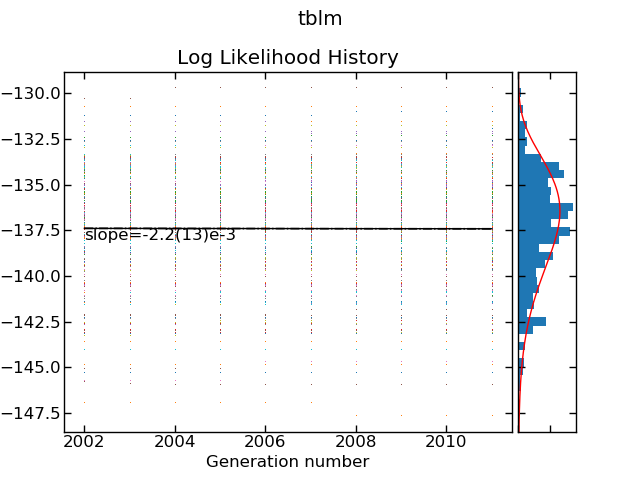

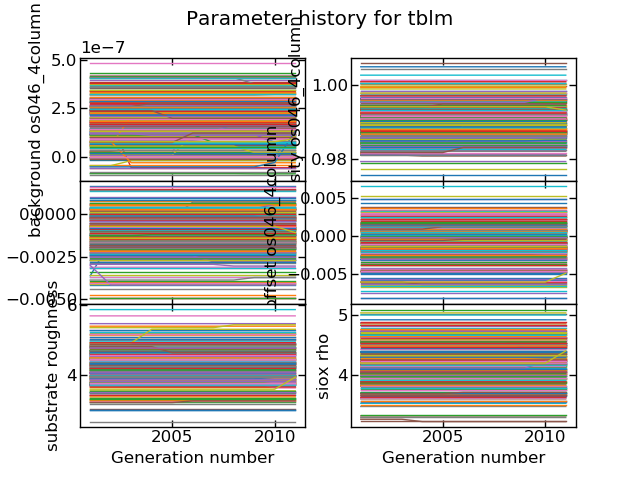

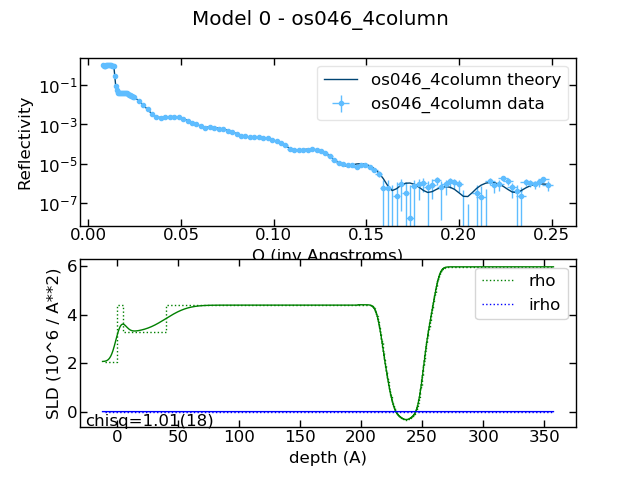

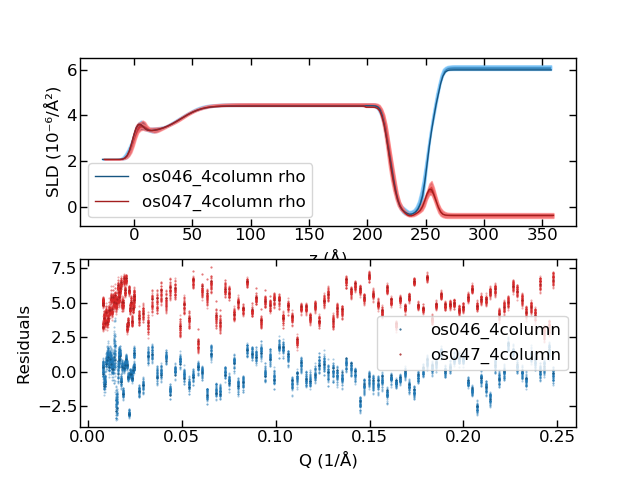

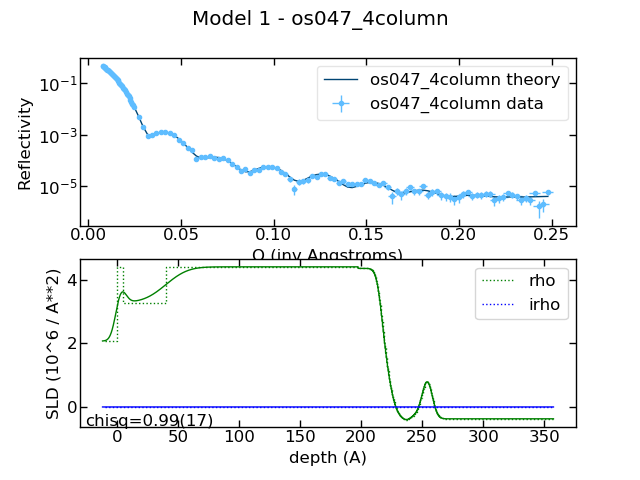

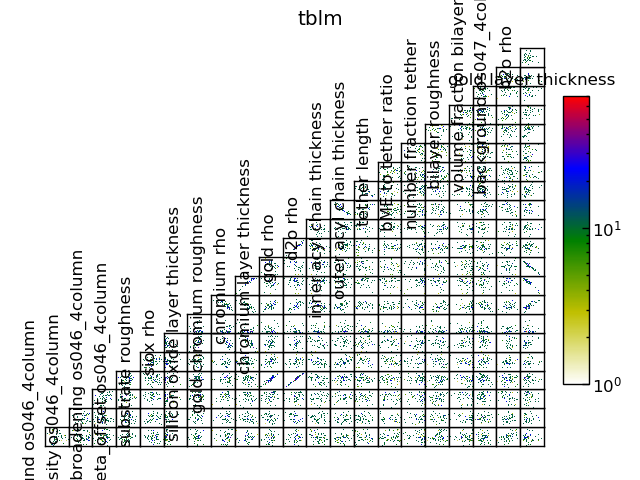

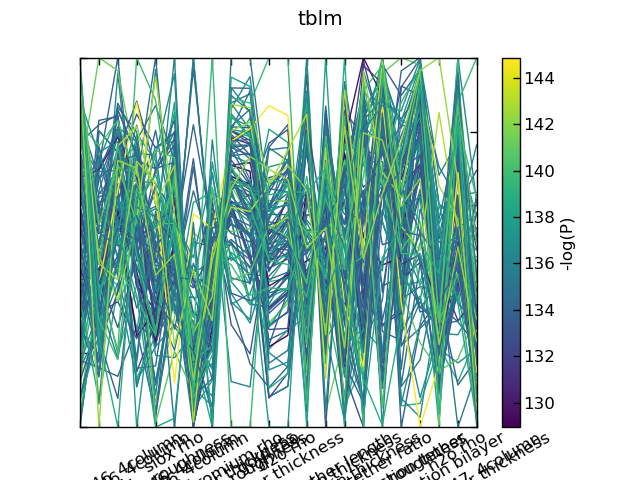

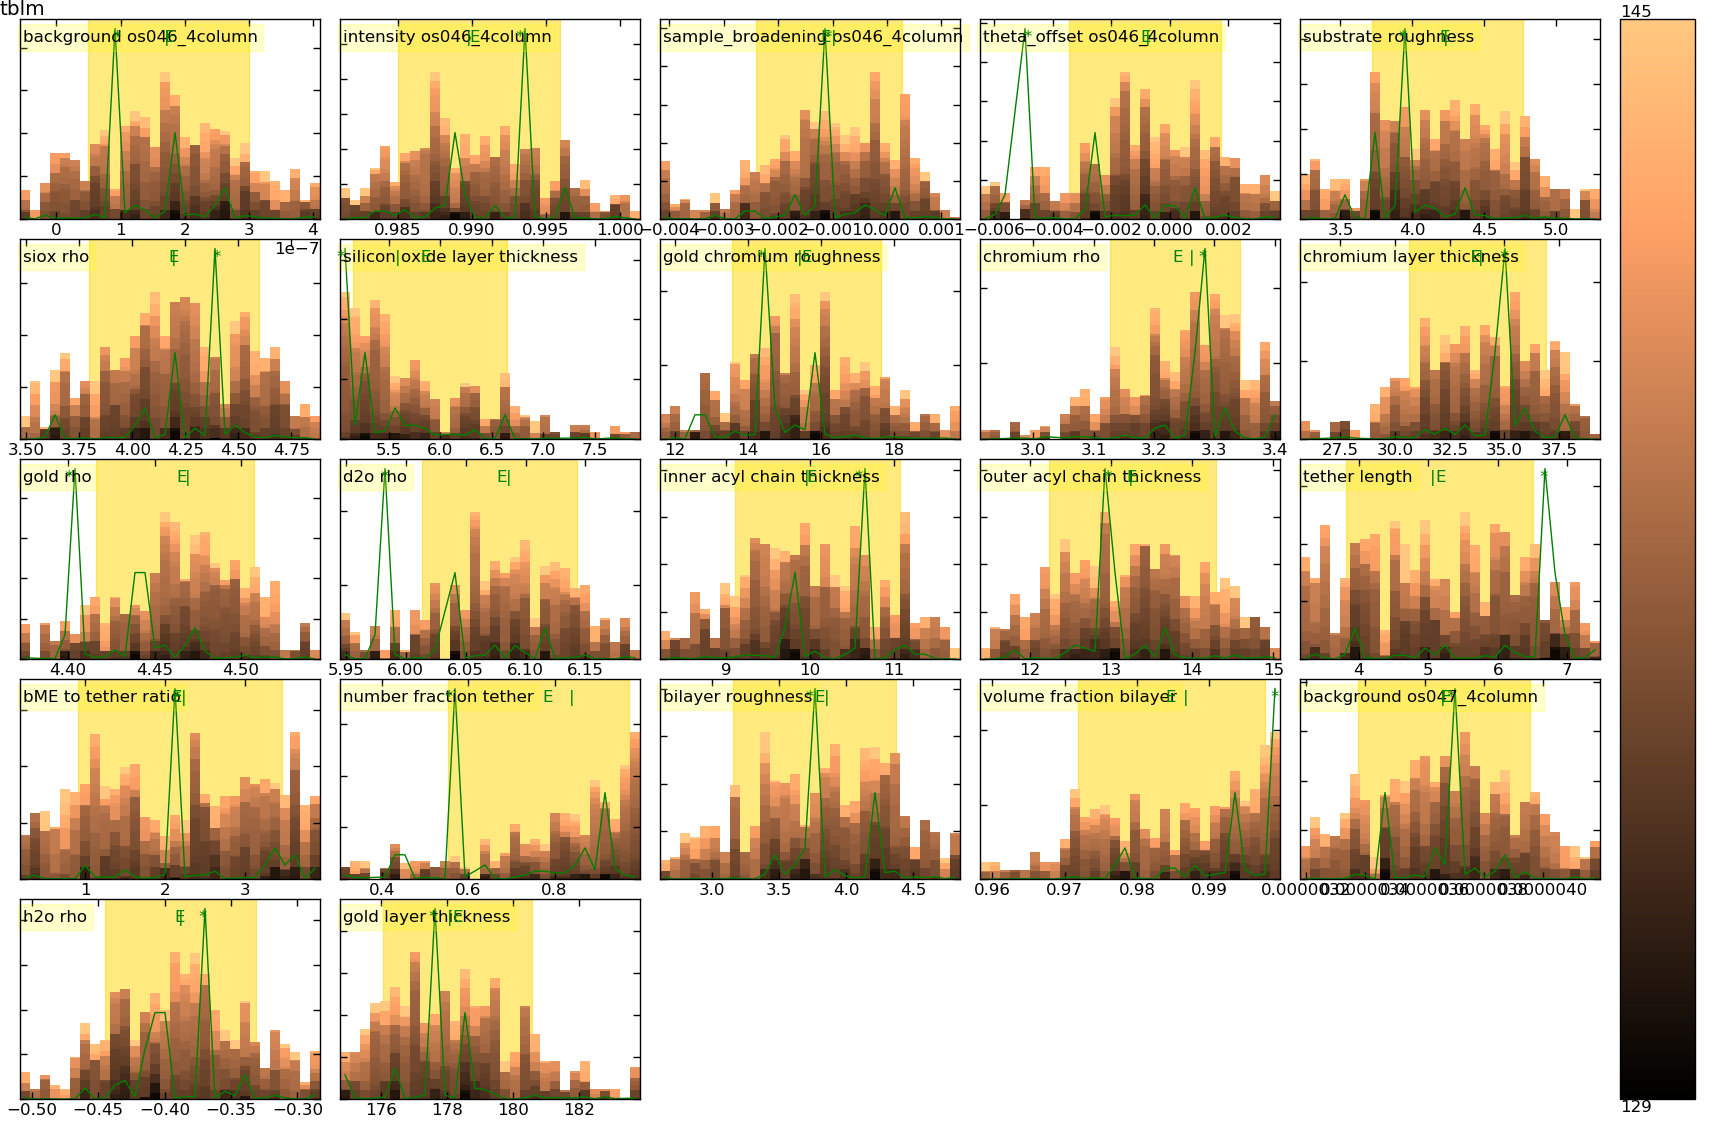

In [8]:
from IPython.display import Image, display
import glob
for file in glob.glob(store+"/*.png"):
    display(Image(filename=file))


# Publication-ready graphs

...

# Useful Routines


Create a HC18 / POPC tethered lipid membrane object and manually change model parameters. Show the molecular
distributions.

In [9]:
blm = mol.tBLM(tether=cmp.HC18SAc, filler=cmp.bmeSAc, lipids=[lipids.POPC], lipid_nf=[1.0])
blm.l_tether = 20.
#blm.fnSetSigma(0.001)
#blm.global_rough=0.001
#blm.tether_methyl_sigma=0.001
#blm.methyl_sigma = blm.methyl_sigma/2.0*0.001
blm.fnAdjustParameters()

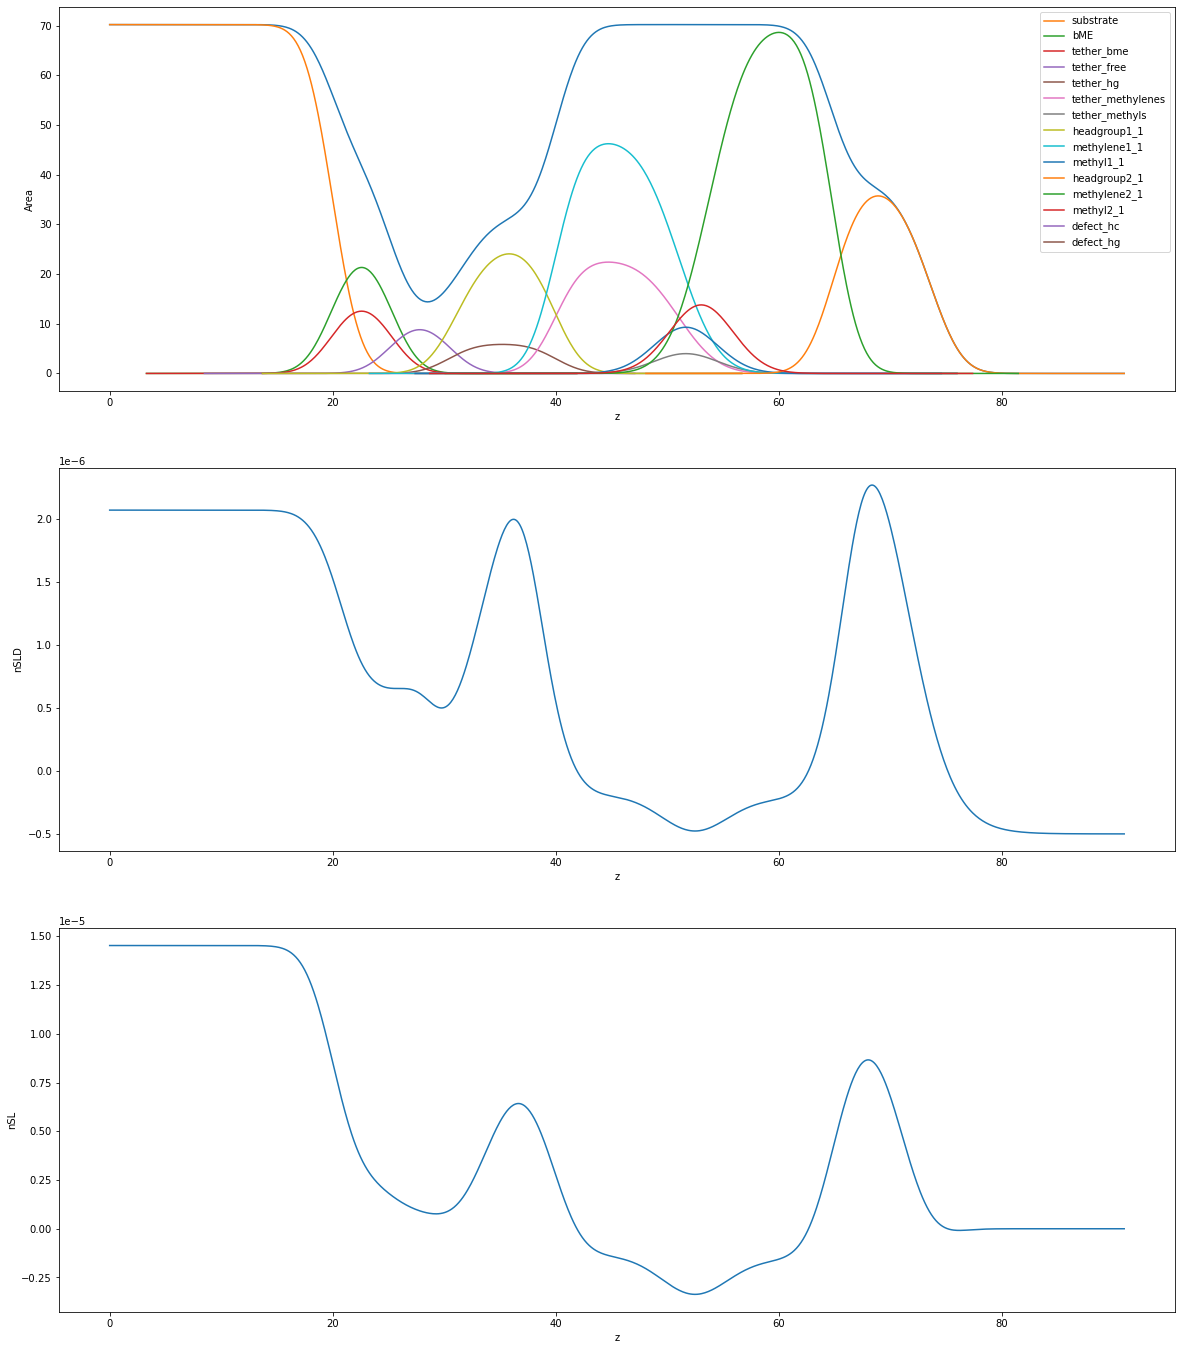

In [10]:
def plot_components(z, blm):
    dd, aArea, anSL = blm.fnWriteProfile(z)
    aArea = np.array(aArea)
    anSL = np.array(anSL)
    sel = aArea>0
    anSLD = anSL[sel] / (aArea[sel] * stepsize)

    fig, ax = plt.subplots(3, 1, figsize=(20,24))
    fig.patch.set_facecolor('white')
    ax[0].plot(z[sel], aArea[sel])
    ax[1].plot(z[sel], anSLD)
    ax[2].plot(z[sel], anSL[sel])
    ax[0].set_ylabel('Area')
    ax[1].set_ylabel('nSLD')
    ax[2].set_ylabel('nSL')
    ax[0].set_xlabel('z')
    ax[1].set_xlabel('z')
    ax[2].set_xlabel('z')

    # plot individual components
    for key, val in blm.__dict__.items():       # cycle over all attributes of blm
        if isinstance(val, mol.nSLDObj):        # if instance of nSLDObj, plot its profile
            ddp, aArea, anSL = val.fnWriteProfile(z)
            aArea = np.array(aArea)
            anSL = np.array(anSL)
            sel = aArea>0
            anSLD = anSL[sel] / (aArea[sel] * stepsize)
            ax[0].plot(z[sel], aArea[sel], '-', label=val.name)
            #ax[1].plot(z[sel], anSLD, '-', label=val.name)
            #ax[2].plot(z[sel], anSL[sel], '-', label=val.name)

    ax[0].legend(loc=0)
    #ax[1].legend(loc=0)
    #ax[2].legend(loc=0)

dimension = 1500
stepsize =0.1
z = np.arange(dimension) * stepsize
plot_components(z, blm)

Load the best-fit tBLM profile and show it.

In [11]:
model = load_model(runfile+'.py')
load_best(model, store+'/'+runfile+'.par')
model.chisq_str()

'2.50(10)'

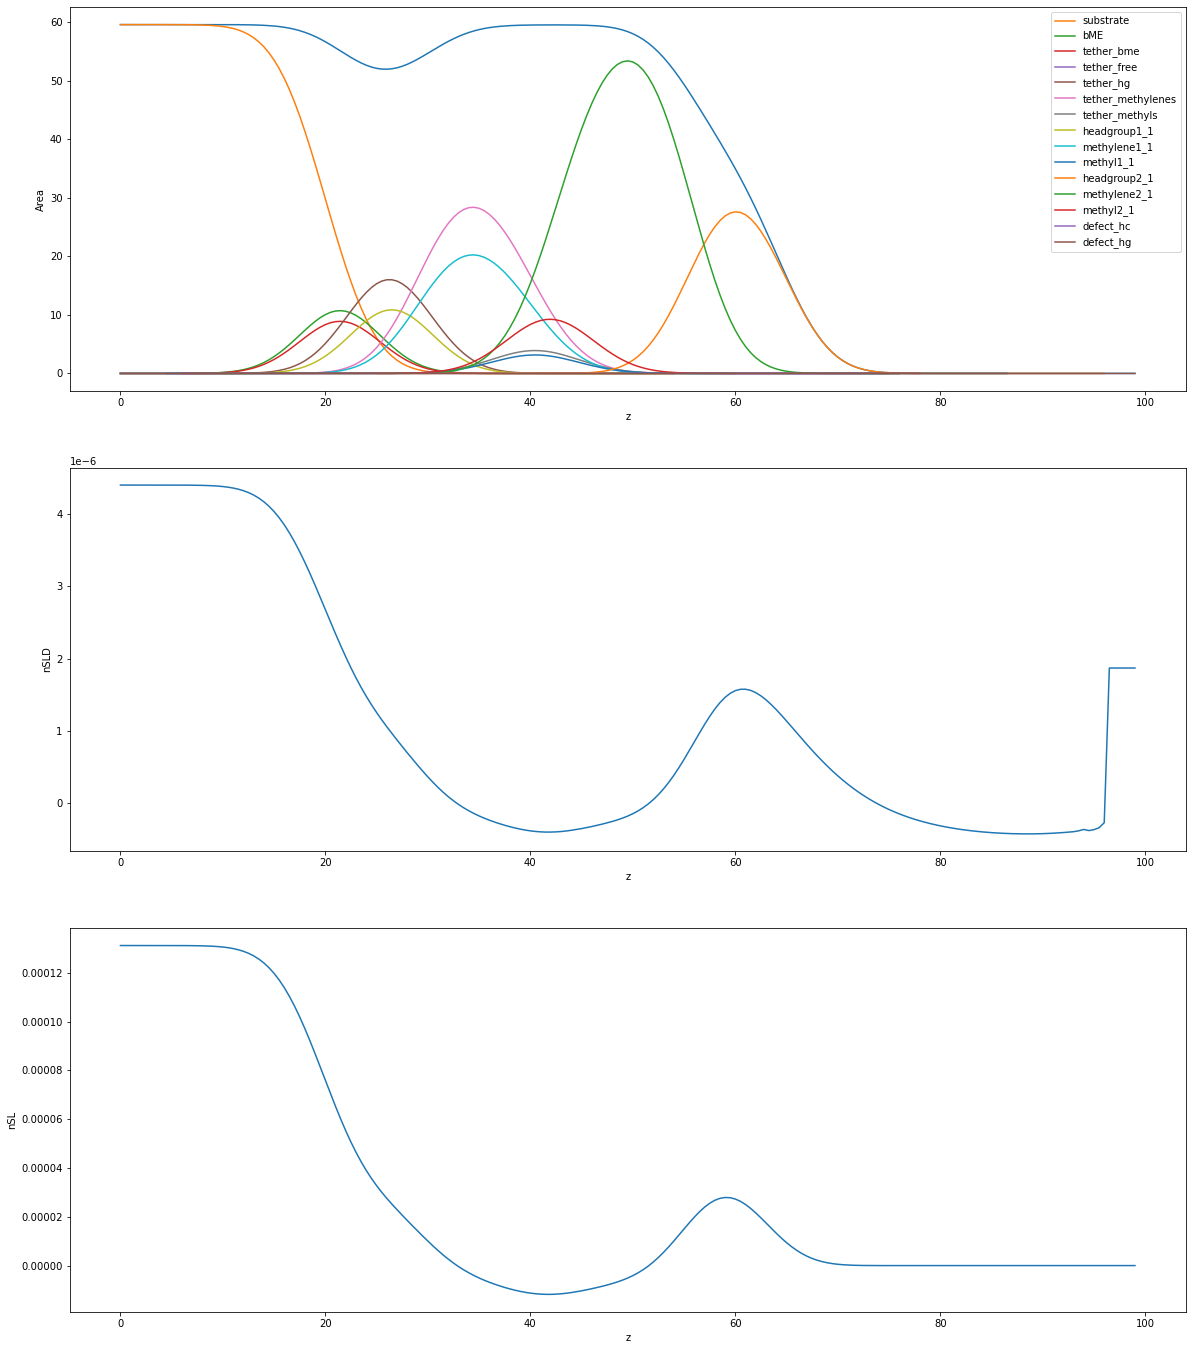

In [12]:
z = np.arange(model.dimension) * model.stepsize
stepsize = model.stepsize
blm = model.bilayers[0]

plot_components(z, model.bilayers[0])

In [13]:
from bumps.dream.state import load_state
state = load_state(store+'/tBLM')
state.mark_outliers() # ignore outlier chains
#state.show()  # Plot statistics

mts 0.978937005217536 0.5371799648360529 0.9828010878597995
lts 10.38323857031208 2.606702655391876 10.197190537988575


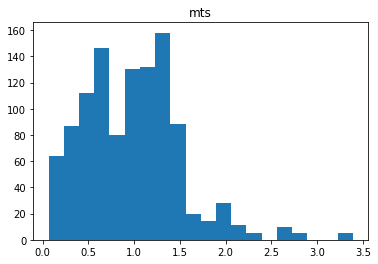

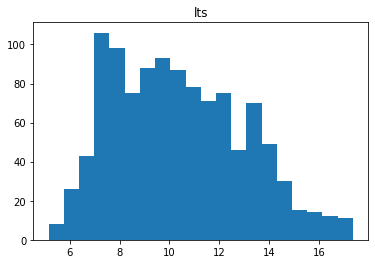

In [14]:
dw = state.draw(thin=5)

# calculate the actual mult_tether and l_tether distributions
mts = list()
lts = list()

for i, d in enumerate(dw.points):
    #if np.mod(i, 100)==0:
    #    print(i, flush=True)
    model.setp(d)
    model.chisq_str()
    mts.append(model.bilayers[0].mult_tether)
    lts.append(model.bilayers[0].l_tether)

plt.figure()
plt.hist(mts, bins=20)
plt.title('mts')

plt.figure()
plt.hist(lts, bins=20)
plt.title('lts')

print('mts', np.mean(mts), np.std(mts), np.median(mts))
print('lts', np.mean(lts), np.std(lts), np.median(lts))


In [15]:
from bumps.dream.stats import credible_interval

print(credible_interval(np.array(mts), [0, 0.68, 0.95]))
print(credible_interval(np.array(lts), [0, 0.68, 0.95]))

[[0.98280109 0.98280109]
 [0.44533146 1.40029089]
 [0.10633347 2.19816074]]
[[10.19719054 10.19719054]
 [ 7.53902579 13.34693177]
 [ 6.31169425 15.80889715]]
